In [27]:
import tushare as ts
import seaborn as sns
import keras
import numpy as np
import pandas as pd
from tcn import TCN
from keras.models import Sequential, Input, Model
from keras import layers
from keras.optimizers import RMSprop
from keras.initializers import Orthogonal
import matplotlib.pyplot as plt
# import jtplot submodule from jupyterthemes
# from jupyterthemes import jtplot

# # currently installed theme will be used to
# # set plot style if no arguments provided
# jtplot.style()
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
ts.set_token('53cd3b985c649c978160c6ec04bce24f4fbd2ebcb4673e8f2fba9a43')

pro = ts.pro_api()

data = pro.daily(ts_code='000001.SZ', start_date='20170817', end_date='20190817')

C:\Users\GreenWood\Anaconda3\envs\tf_gpu_keras\lib\site-packages\tushare\util\upass.py:28: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return str(df.ix[0]['token'])


In [4]:
data = data.drop(['ts_code'], axis=1)
data['trade_date'] = pd.to_datetime(data['trade_date'])
data = data.set_index('trade_date')
data = data[::-1]

In [5]:
data.tail()

,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,
2019-08-12,14.61,15.12,14.60,15.12,14.52,0.60,4.1322,2733425.47,4084497.902
2019-08-13,15.00,15.08,14.74,14.89,15.12,-0.23,-1.5212,1293736.44,1925835.288
2019-08-14,15.14,15.22,14.80,14.97,14.89,0.08,0.5373,1360546.54,2038261.151
2019-08-15,14.64,14.96,14.60,14.94,14.97,-0.03,-0.2004,897376.26,1333117.725
2019-08-16,15.09,15.14,14.78,14.90,14.94,-0.04,-0.2677,986902.93,1474900.257


In [6]:
train_mean = data[:'2019-01-17'].mean()
train_std = data[:'2019-01-17'].std()

data -= train_mean
data /= train_std

train_size = len(data[:'2019-01-17'])
test_size = len(data) - train_size

In [7]:
train_size

347

In [8]:
test_size

141

In [10]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][3]
        yield samples, targets

In [21]:
def plot_loss(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [127]:
lookback = 32
step = 1
delay = 1
batch_size = 16

data_values = data.values
train_gen = generator(data_values,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=train_size,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
test_gen = generator(data_values,
                     lookback=lookback,
                     delay=delay,
                     min_index=train_size,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

test_steps = (len(data_values) - train_size - lookback) // batch_size

In [128]:
def get_model(batch_size, timesteps, input_dim):
    i = Input(batch_shape=(batch_size, timesteps, input_dim))
    x = TCN(nb_filters=64, 
            kernel_size=2, 
            dilations=[1, 2, 4, 8, 16], 
            nb_stacks=1, 
            dropout_rate=0.3,
            kernel_initializer=Orthogonal(seed=7),
            use_skip_connections=True,
            return_sequences=False)(i)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    y = layers.Dense(1)(x)
    model = Model(inputs=[i], outputs=[y])
    return model

In [129]:
model = get_model(batch_size, lookback, 9)
model.compile(optimizer=RMSprop(), loss='mse')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (8, 32, 9)           0                                            
__________________________________________________________________________________________________
conv1d_461 (Conv1D)             (8, 32, 64)          640         input_24[0][0]                   
__________________________________________________________________________________________________
conv1d_462 (Conv1D)             (8, 32, 64)          8256        conv1d_461[0][0]                 
__________________________________________________________________________________________________
activation_439 (Activation)     (8, 32, 64)          0           conv1d_462[0][0]                 
__________________________________________________________________________________________________
spatial_dr

In [130]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=80,
                              epochs=20,
                              validation_data=test_gen,
                              validation_steps=test_steps)

Epoch 1/20
80/80 [==============================] - 13s 160ms/step - loss: 0.7791 - val_loss: 0.2105
Epoch 2/20
80/80 [==============================] - 2s 27ms/step - loss: 0.3863 - val_loss: 0.2951
Epoch 3/20
80/80 [==============================] - 3s 40ms/step - loss: 0.3348 - val_loss: 0.3040
Epoch 4/20
80/80 [==============================] - 2s 22ms/step - loss: 0.2174 - val_loss: 0.2510
Epoch 5/20
80/80 [==============================] - 2s 19ms/step - loss: 0.2091 - val_loss: 0.4231
Epoch 6/20
80/80 [==============================] - 2s 20ms/step - loss: 0.2160 - val_loss: 0.1614
Epoch 7/20
80/80 [==============================] - 2s 21ms/step - loss: 0.1932 - val_loss: 0.0969
Epoch 8/20
80/80 [==============================] - 2s 20ms/step - loss: 0.1813 - val_loss: 0.2763
Epoch 9/20
80/80 [==============================] - 2s 20ms/step - loss: 0.1578 - val_loss: 0.3471
Epoch 10/20
80/80 [==============================] - 2s 20ms/step - loss: 0.1707 - val_loss: 0.1543
Epoch 1

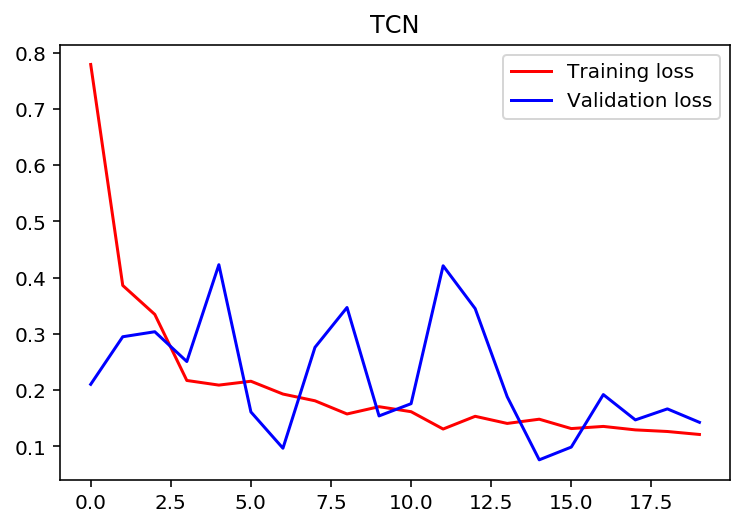

In [131]:
plot_loss(history, 'TCN')

In [132]:
test_set = data_values[train_size:]
real_val = test_set[lookback:, 3]
pred_val = []
for i in range(test_size - lookback):
    window = test_set[i: i + lookback]
    window = window.reshape(1, len(window), -1)
    pred_val.append(model.predict(window)[0, 0])
pred_val = np.array(pred_val)

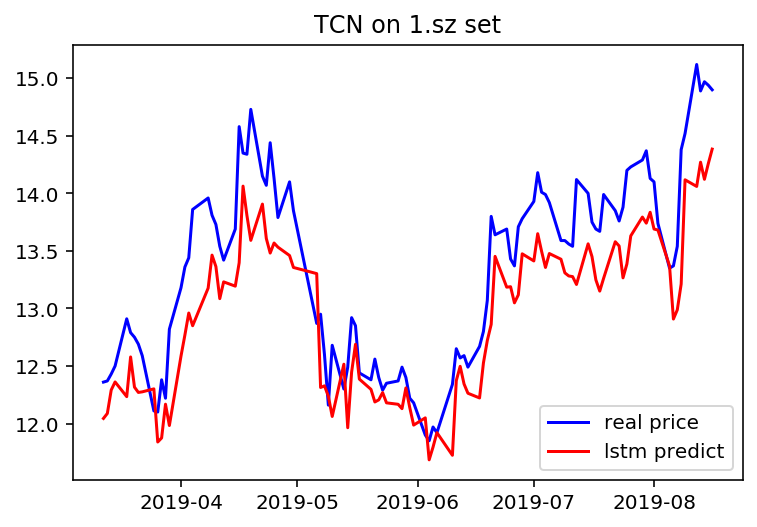

In [133]:
date = data.iloc[train_size + lookback:].index
real_val = real_val * train_std['close'] + train_mean['close']
pred_val = pred_val * train_std['close'] + train_mean['close']
plt.figure()

plt.plot(date, real_val, 'b', label='real price')
plt.plot(date, pred_val, 'r', label='lstm predict')
plt.title('TCN on 1.sz set')
plt.legend()

plt.show()